In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output  # this has to be removed if used on a single script
import random
from preprocess import preprocess_seismo, preprocess_coord
from scipy.ndimage.interpolation import shift
import GPy
import time

/home/alessio/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alessio/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alessio/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alessio/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
def next_batch(x, y, mb_size):
    idx = np.arange(len(x), dtype = np.int64)
    np.random.shuffle(idx)
    idx = idx[:mb_size]
    return x[idx], y[idx], idx

def plot(x, index=0):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(x, label='Reconstructed')
    plt.plot(X_data[index], label='Real')
    plt.legend()

def plot_test(x, index=0):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(x, label='Reconstructed')
    plt.plot(X_data_test[index], label='Real')
    plt.legend()

def calculate_R2(original, prediction, label, store):
    AM = original.mean()
    BM = prediction.mean()
    c_vect = (original-AM)*(prediction-BM)
    d_vect = (original-AM)**2
    e_vect = (prediction-BM)**2
    r_out = np.sum(c_vect)/float(np.sqrt(np.sum(d_vect)*np.sum(e_vect)))
    print(label+str(r_out))
    store.append(r_out)

In [3]:
X_dim = 501 # size of the seismograms
y_dim = 4
# load data
split = 2000
test_valid = 1000
X_data_ = np.loadtxt('./seismograms_4000seismo_ISO.txt')[:, :X_dim]
y_data_ = np.loadtxt('./coordinates_4000seismo_ISO.txt')

In [4]:
# analysis starts here, so we start counting time from here
#start_time = time.time()

In [5]:
# preprocess coordinates
y_data_preprocessed, meancoords, stdcoords = preprocess_coord(y_data_, split=split, test_valid=test_valid, sort=False, std=True)
y_data = y_data_preprocessed[:split]
y_data_valid = y_data_preprocessed[split:split+test_valid]
y_data_test = y_data_preprocessed[split+test_valid:]

Shifted and standardized; not sorted
Mean: [-1.49500000e-01  6.00000000e-02 -1.23196500e+02  1.29906166e+02], std dev: [23.03473789 23.21808347 68.8275736  64.09918073]


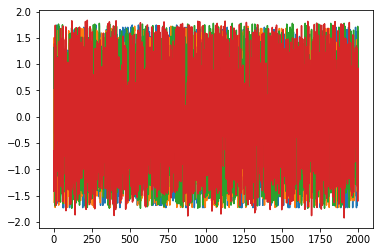

In [6]:
for i in range(y_dim):
    plt.plot(y_data[:, i])

In [7]:
# preprocess seismograms
X_data_preprocessed = preprocess_seismo(X_data_, split, log=False, std=True, rescale=True, rescale_onlyamp=False)
X_data = X_data_preprocessed[:split]
X_data_valid =  X_data_preprocessed[split:split+test_valid]
X_data_test =  X_data_preprocessed[split+test_valid:]

('Amplitude of first peak in reference seismo', 4476.40283203125)
('Time index of first peak in reference seismo', 204)
Saving amplitude ratios and shift indices
Rescaling and standardizing
Mean: 1.02427538448, std dev: 514.828690747


In [8]:
amplitude_rescale = np.loadtxt('./amplitude_rescale_NOTsorted.txt')
shift_index = np.loadtxt('./shift_index_NOTsorted.txt')

In [9]:
amplitude_rescale_train = amplitude_rescale[:split].reshape(X_data.shape[0], 1)
amplitude_rescale_valid = amplitude_rescale[split:split+test_valid]
amplitude_rescale_test = amplitude_rescale[split+test_valid:]

shift_index_train = shift_index[:split].reshape(X_data.shape[0], 1)
shift_index_valid = shift_index[split:split+test_valid]
shift_index_test = shift_index[split+test_valid:]

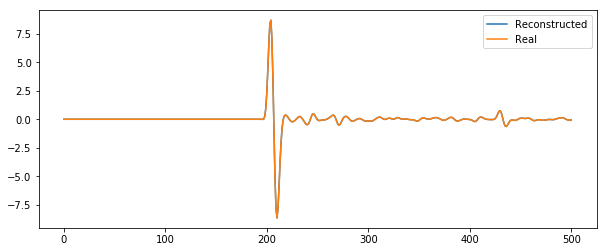

In [10]:
plot(X_data[0], 0)

In [11]:
mb_size = 256 # batch size
z_dim = 64 # dimension of latent space
h1_dim = 256 # dimension of the hidden layer, i.e. number of nodes
h2_dim = 128 # dimension of the hidden layer, i.e. number of nodes
h3_dim = 64 # dimension of the hidden layer, i.e. number of nodes
h4_dim = 32 # dimension of the hidden layer, i.e. number of nodes
h_dim = 50 # final part of the discriminator
act_f = 'leaky_relu' # activation function
lr = 1e-4  # learning rate
lambda_ = 10.0
num_critic = 100

In [12]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=[None, X_dim])
c = tf.placeholder(tf.float32, shape=[None, y_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])

def generator(coord, zed):
    with tf.variable_scope('g_'):
        inputs = tf.concat(axis=1, values=[zed, coord])
        h4 = tf.layers.dense(coord, h4_dim, activation=getattr(tf.nn, act_f))
        h3 = tf.layers.dense(h4, h3_dim, activation=getattr(tf.nn, act_f))
        h2 = tf.layers.dense(h3, h2_dim, activation=getattr(tf.nn, act_f))
        h = tf.layers.dense(h2, h1_dim, activation=getattr(tf.nn, act_f))
        logits = tf.layers.dense(h, X_dim)
        return logits

def discriminator(data, coord, is_reuse=False):
    with tf.variable_scope('d_') as scope:
        if is_reuse is True:
            scope.reuse_variables()
        h2 = tf.layers.dense(data, h1_dim, activation=getattr(tf.nn, act_f))
        h2_cat = tf.concat(axis=1, values=[h2, coord])
        h = tf.layers.dense(h2_cat, h_dim, activation=getattr(tf.nn, act_f))
        logits = tf.layers.dense(h, 1)
        return logits

In [13]:
g_samples = generator(c, z)
d_logit_real = discriminator(X, c)
d_logit_fake = discriminator(g_samples, c, is_reuse=True)

# discriminator loss
wgan_d_loss = tf.reduce_mean(d_logit_fake) - tf.reduce_mean(d_logit_real)

# generator loss
g_loss = -tf.reduce_mean(d_logit_fake)

d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='d_')
g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='g_')

# gradient penalty
alpha = tf.random_uniform(shape=[tf.shape(X)[0], 1], minval=0., maxval=1.)
differences = g_samples - X
interpolates = X + (alpha * differences)
gradients = tf.gradients(discriminator(interpolates, c, is_reuse=True), [interpolates])[0]
slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
gradient_penalty = tf.reduce_mean((slopes-1.)**2)

d_loss = wgan_d_loss + lambda_ * gradient_penalty

# Optimizers for generator and discriminator
gen_optim = tf.train.AdamOptimizer(
    learning_rate=lr, beta1=0.0, beta2=0.9).minimize(g_loss, var_list=g_vars)
dis_optim = tf.train.AdamOptimizer(
    learning_rate=lr, beta1=0.0, beta2=0.9).minimize(d_loss, var_list=d_vars)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
saver = tf.train.Saver(max_to_keep=None)

sess = tf.Session()

sess.run(tf.global_variables_initializer())

In [ ]:
# losses_wgan, losses_gp, losses_d, losses_g = [], [], [], []
# losses_wgan_valid, losses_gp_valid, losses_d_valid, losses_g_valid = [], [], [], []

# training_WGANGP_R2 = []
# validation_WGANGP_R2 = []
# test_WGANGP_R2 = []

# n_iter = 1000000 # number of iterations
# best_loss = 1e8
# stopping_step = 0
# patience = 200

# for it in range(n_iter):
    
#     # train critic
#     for idx in range(num_critic):
#         random_perm = np.random.permutation(X_data.shape[0])
#         indices = random_perm[:mb_size]
#         _, wgan_d_loss_, gp_loss_, d_loss_ = sess.run([dis_optim, wgan_d_loss, gradient_penalty, d_loss], feed_dict={X: X_data[indices], c: y_data[indices], z: np.random.uniform(-1., 1., size=[mb_size, z_dim])})

#     # train generator
#     random_perm = np.random.permutation(X_data.shape[0])
#     indices = random_perm[:mb_size]     
#     _, g_loss_ = sess.run([gen_optim, g_loss], feed_dict={X: X_data[indices], c: y_data[indices], z: np.random.uniform(-1., 1., size=[mb_size, z_dim])})

#     # metrics
#     clear_output(wait=True)

#     # test set performance, only wgan loss
#     dis_feed = {c: y_data_valid, X: X_data_valid, z: np.random.uniform(-1., 1., size=[X_data_valid.shape[0], z_dim])}
#     dis_run = [wgan_d_loss, gradient_penalty, d_loss]
#     wgan_d_loss_valid, gp_loss_valid, d_loss_valid = sess.run(dis_run, feed_dict=dis_feed)
    
#     # generator validation loss
#     gen_feed = {c: y_data_valid, X: X_data_valid, z: np.random.uniform(-1., 1., size=[X_data_valid.shape[0], z_dim])}
#     _, g_loss_valid = sess.run([gen_optim, g_loss], feed_dict=gen_feed)
    
#     # negative critic loss
#     #losses_wgan.append(-wgan_d_loss_)
#     #losses_gp.append(gp_loss_)
#     losses_d.append(-d_loss_)
#     #losses_g.append(g_loss_)

#     losses_d_valid.append(-d_loss_valid)
#     #losses_gp_valid.append(gp_loss_valid)
#     #losses_g_valid.append(g_loss_valid)

#     print('Iter: {}'.format(it))
#     print('Discriminator loss: {:.4}'.format(np.mean(-d_loss_)))
#     print('Validation discriminator loss: {:.4}'.format(np.mean(-d_loss_valid)))

#     #X_R2, y_R2, _ = next_batch(X_data, y_data, test_valid)
#     #prediction_training = sess.run(g_samples, feed_dict={c: y_R2, z: np.random.uniform(-1., 1., size=[test_valid, z_dim])})
#     #calculate_R2(X_R2, prediction_training, 'Training WGANGP: ', training_WGANGP_R2)
#     #prediction_validation = sess.run(g_samples, feed_dict={c: y_data_valid, z: np.random.uniform(-1., 1., size=[y_data_valid.shape[0], z_dim])})
#     #calculate_R2(X_data_valid, prediction_validation, 'Validation WGANGP: ', validation_WGANGP_R2)
#     #prediction_test = sess.run(g_samples, feed_dict={c: y_data_test, z: np.random.uniform(-1., 1., size=[y_data_test.shape[0], z_dim])})
#     #calculate_R2(X_data_test, prediction_test, 'Test WGANGP: ', test_WGANGP_R2)

#     loss_value = np.mean(-d_loss_valid)
#     if it > 100:
#         if loss_value < best_loss:
#             stopping_step = 0
#             best_loss = loss_value
#             save_path = saver.save(sess, f"./saved_models_iso_WGANGP/best_model.ckpt")
#         else:
#             stopping_step += 1
#             print(f'Early stopping: {stopping_step}/{patience}')
#         if stopping_step >= patience:
#             print(f'Patience limit reached at iteration {it}')
#             break

In [ ]:
# fig = plt.figure(figsize=(10, 4))
# plt.plot(losses_d, label='Training')        
# plt.plot(losses_d_valid, label='Validation')        
# plt.legend()
# plt.show()

In [15]:
# load best model
#print(f'Best model was model {len(losses_d) - patience}')
load_path = ("./saved_models_iso_WGANGP/best_model.ckpt")
saver.restore(sess, load_path)

INFO:tensorflow:Restoring parameters from ./saved_models_iso_WGANGP/best_model.ckpt


In [ ]:
# # fit GP to data rescaling
# # amplitude
# kern = GPy.kern.Matern32(4,ARD=True)
# n = GPy.models.GPRegression(y_data, amplitude_rescale_train, kern)
# n.optimize(messages=True, max_f_eval = 1000)

# # GP softwares should have regularisation techniques to prevent overfitting
# # already implemented. This way, we can just look at training performance, 
# # as in, that training converged, to be quite sure it did not overfit.
# # As a confirmation of this, we print train and validation R2 scores, 
# # and check they are compatible. If they are not, then overfit happened,
# # maybe because the size sample was too small and regularisation techniques failed.
# # If they are on par, then there is good generalisation and no signs of overfitting.
# # We note that overfitting may have happened anyway, as this is just a necessary, 
# # but not sufficient, condition. However, we expect the algorithm to be robust enough
# # when trained on these representative data that by just looking at train and
# # validation R2 values we can exclude overfitting.

# y_pred_train = n.predict(y_data)[0]
# y_pred_train = y_pred_train[:, 0]
# calculate_R2(amplitude_rescale_train.flatten(), y_pred_train, 'Amplitude R2 train: ', [])

# y_pred_valid = n.predict(y_data_valid)[0]
# y_pred_valid = y_pred_valid[:, 0]
# calculate_R2(amplitude_rescale_valid, y_pred_valid, 'Amplitude R2 validation: ', [])

# # this is to be used later
# y_pred_test = n.predict(y_data_test)[0]
# y_pred_test = y_pred_test[:, 0]

# #plt.plot(amplitude_rescale_test, color='blue')
# #plt.show()
# #plt.plot(y_pred_test, color='red')
# #plt.show()

In [ ]:
# # time shift
# ker = GPy.kern.Matern32(4,ARD=True)
# m = GPy.models.GPRegression(y_data,shift_index_train,ker)
# m.optimize(messages=True,max_f_eval = 1000)

# y_pred_train_2 = m.predict(y_data)[0]
# y_pred_train_2 = y_pred_train_2[:, 0]
# calculate_R2(shift_index_train.flatten(), y_pred_train_2, 'Time shift R2 training: ', [])

# y_pred_valid_2 = m.predict(y_data_valid)[0]
# y_pred_valid_2 = y_pred_valid_2[:, 0]
# calculate_R2(shift_index_valid, y_pred_valid_2, 'Time shift R2 validation: ', [])

# y_pred_test_2 = m.predict(y_data_test)[0]
# y_pred_test_2 = y_pred_test_2[:, 0]

# #plt.plot(shift_index_test, color='blue')
# #plt.show()
# #plt.plot(y_pred_test_2, color='red')
# #plt.show()

In [16]:
ker = GPy.kern.Matern32(4,ARD=True) 
m_load = GPy.models.GPRegression(y_data, amplitude_rescale_train, ker, initialize=False)
m_load.update_model(False) # do not call the underlying expensive algebra on load
m_load.initialize_parameter() # Initialize the parameters (connect the parameters up)
m_load[:] = np.load('./saved_models_iso_WGANGP/GPmodel_amplitude.npy') # Load the parameters
m_load.update_model(True) # Call the algebra only once

# this is to be used later
y_pred_test = m_load.predict(y_data_test)[0]
y_pred_test = y_pred_test[:, 0]



kern = GPy.kern.Matern32(4,ARD=True) 
n_load = GPy.models.GPRegression(y_data, shift_index_train, kern, initialize=False)
n_load.update_model(False) # do not call the underlying expensive algebra on load
n_load.initialize_parameter() # Initialize the parameters (connect the parameters up)
n_load[:] = np.load('./saved_models_iso_WGANGP/GPmodel_time.npy') # Load the parameters
n_load.update_model(True) # Call the algebra only once

y_pred_test_2 = n_load.predict(y_data_test)[0]
y_pred_test_2 = y_pred_test_2[:, 0]


 /home/alessio/anaconda3/lib/python2.7/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


In [ ]:
# start_time_inference = time.time()

# coordinate = np.array([31,25,158])

# shifted = coordinate - np.array([41,41,244])
# distances = np.linalg.norm(shifted)
# new_coords = np.zeros(4)
# new_coords[:3] = shifted
# new_coords[-1] = distances
# new_coords = (new_coords - meancoords)/stdcoords
# new_coords = new_coords.reshape((1,y_dim))

# prediction_testing = sess.run(g_samples, feed_dict={c: y_data_test, z: np.random.uniform(-1., 1., size=[test_valid, z_dim])})
# mean, std = 1.0242753844768389, 514.82869074668
# prediction_testing = prediction_testing*std + mean
# y_pred_test = m_load.predict(new_coords)[0]
# y_pred_test = y_pred_test[:, 0]
# y_pred_test_2 = n_load.predict(new_coords)[0]
# y_pred_test_2 = y_pred_test_2[:, 0]
# prediction_testing = np.multiply(prediction_testing, np.repeat(1/y_pred_test, X_dim).reshape(-1, X_dim))
# for i in range(test_valid):
#     prediction_testing[i] = shift(prediction_testing[i], -y_pred_test_2[i], cval=0.)

# for j in range(10):
#     plt.plot(X_data_[split+test_valid+j,:], color='blue')
#     plt.plot(prediction_testing[i], color='red')
#     plt.show()
# timeinf = time.time() - start_time_inference
# print("timeinf", timeinf)
# np.save("WGANGP_inftime.npy", timeinf)

In [ ]:
prediction_testing = sess.run(g_samples, feed_dict={c: y_data_test, z: np.random.uniform(-1., 1., size=[y_data_test.shape[0], z_dim])})

mean, std = 1.0242753844768389, 514.82869074668

prediction_testing = prediction_testing*std + mean

prediction_testing = np.multiply(prediction_testing, np.repeat(1/y_pred_test, X_dim).reshape(-1, X_dim))
for index_seism in range(test_valid):
    prediction_testing[index_seism] = shift(prediction_testing[index_seism], -y_pred_test_2[index_seism], cval=0.)

# retrieve the unprocessed data back
X_data_preprocessed = preprocess_seismo(X_data_, split, log=False, std=False, rescale=False, rescale_onlyamp=False)
X_data_test = X_data_preprocessed[split+test_valid:]

calculate_R2(X_data_test, prediction_testing, 'Final R2 testing: ', [])

for i in range(10):
    print(y_data_test[i])
    plt.plot(X_data_test[i], color='blue')
    plt.plot(prediction_testing[i], color='red')
    plt.show()
np.save('seismorec_test_WGAN-GP.npy', prediction_testing)

In [ ]:
# total time, to be quoted in the paper
#print("--- %s seconds ---" % (time.time() - start_time))

In [4]:
coords = np.loadtxt('./coordinates_4000seismo_ISO.txt')
coords_test = coords[split+test_valid:]

In [5]:
X_data_test = np.load('./X_data_test.npy')

In [6]:
sap = np.load('./seismorec_test_D18.npy')
wgan = np.load('./seismorec_test_WGAN-GP.npy')
nn = np.load('./seismorec_test_NNdirect.npy')

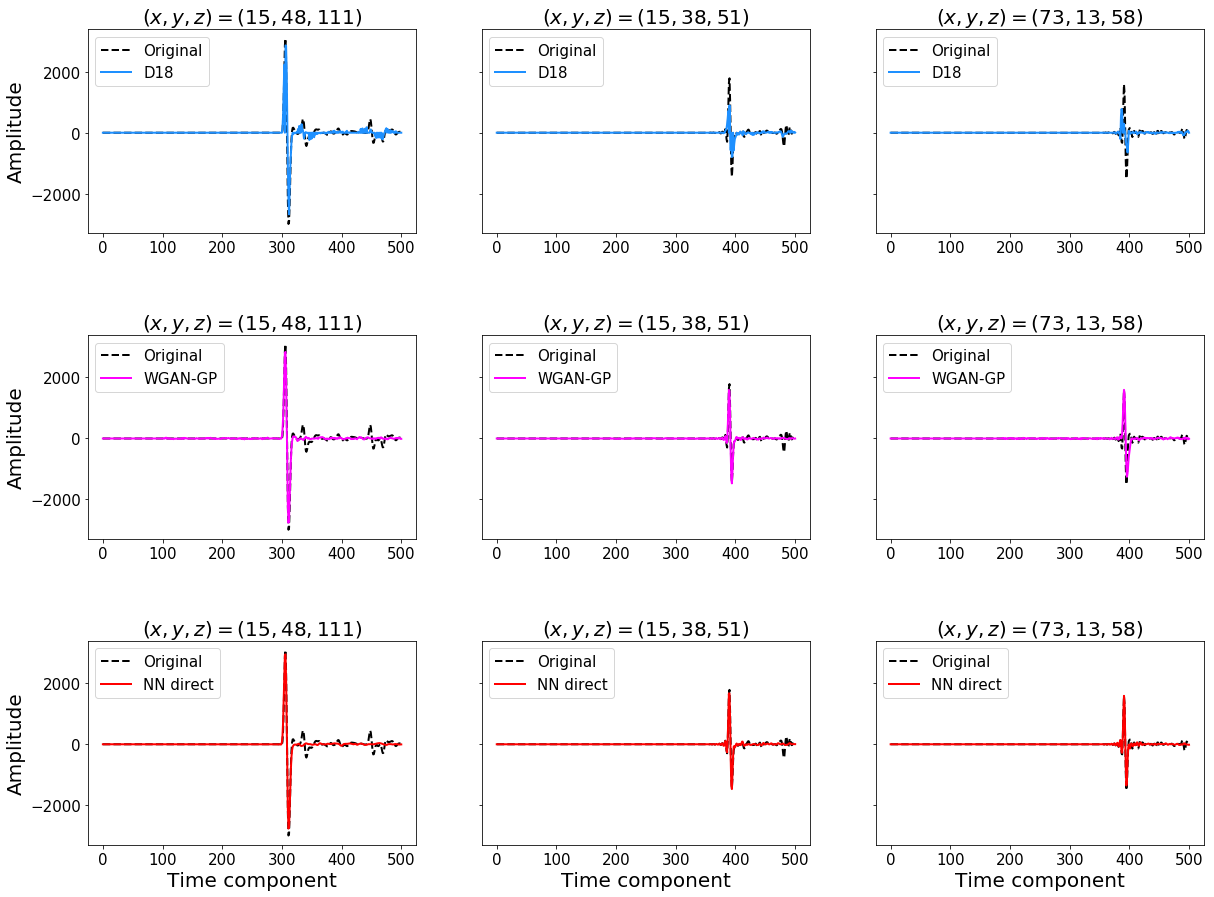

In [7]:
num = 0
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,5), sharey=True)
for i in range(3):
    for j in range(3):
        ax[i,j].tick_params(axis='both', which='major', labelsize=15)
        ax[i,j].tick_params(axis='both', which='minor', labelsize=15)
        if j == 0:
            ax[i,j].set_ylabel('Amplitude', fontsize=20)
            num=102
        if j == 1:
            num=435
        if j == 2:
            num=860
        if i == 0:
            ax[i,j].set_title('$(x,y,z)=({:3.0f},{:3.0f},{:3.0f})$'.format(coords_test[num][0], coords_test[num][1], coords_test[num][2]), size=20)
            ax[i,j].plot(X_data_test[num], color='black', label='Original', linestyle='--', linewidth=2)
            ax[i,j].plot(sap[num], color='dodgerblue', label='D18', linewidth=2)
            ax[i,j].legend(loc='upper left', fontsize=15)
        if i == 1:
            ax[i,j].set_title('$(x,y,z)=({:3.0f},{:3.0f},{:3.0f})$'.format(coords_test[num][0], coords_test[num][1], coords_test[num][2]), size=20)
            ax[i,j].plot(X_data_test[num], color='black', label='Original', linestyle='--', linewidth=2)
            ax[i,j].plot(wgan[num], color='fuchsia', label='WGAN-GP', linewidth=2)
            ax[i,j].legend(loc='upper left', fontsize=15)
        if i == 2:
            ax[i,j].set_title('$(x,y,z)=({:3.0f},{:3.0f},{:3.0f})$'.format(coords_test[num][0], coords_test[num][1], coords_test[num][2]), size=20)
            ax[i,j].plot(X_data_test[num], color='black', label='Original', linestyle='--', linewidth=2)
            ax[i,j].plot(nn[num], color='red', label='NN direct', linewidth=2)
            ax[i,j].legend(loc='upper left', fontsize=15)
            ax[i,j].set_xlabel('Time component', fontsize=20)
fig.set_size_inches(10 + fig.get_size_inches())
plt.subplots_adjust(hspace=0.5, wspace=0.2)
plt.savefig('comparison.pdf')

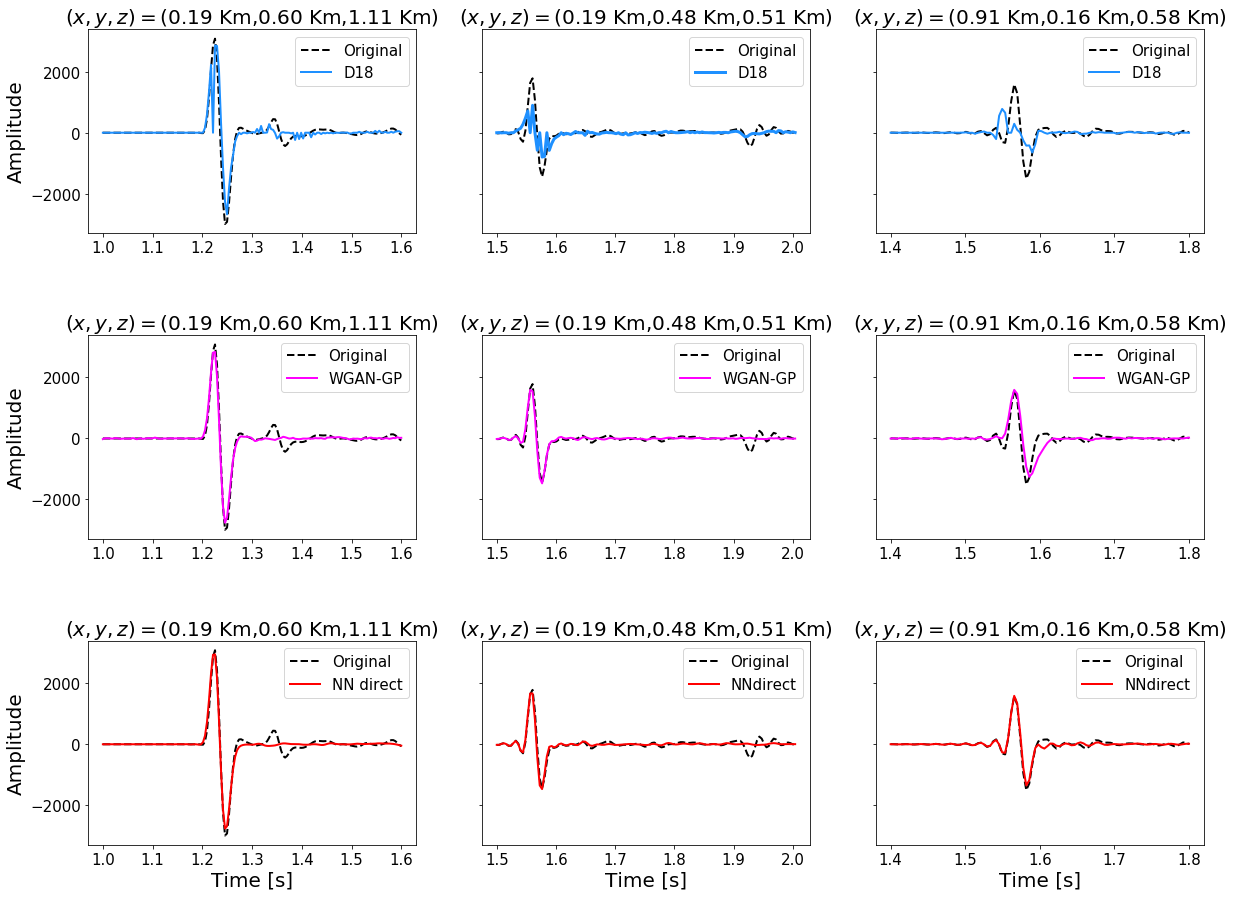

In [25]:
num = 0
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,5), sharey=True)
for i in range(3):
    for j in range(3):
        ax[i,j].tick_params(axis='both', which='major', labelsize=15)
        ax[i,j].tick_params(axis='both', which='minor', labelsize=15)
        if j == 0:
            ax[i,j].set_ylabel('Amplitude', fontsize=20)
            num=102
            start = 250
            stop = 400
            xax = np.linspace(0.004*start, 0.004*stop, num=stop-start)
            if i == 0:
                ax[i,j].set_title('$(x,y,z)=({:3.2f}$ Km,${:3.2f}$ Km,${:3.2f}$ Km)'.format(coords_test[num][0]*0.0125, coords_test[num][1]*0.0125, coords_test[num][2]*0.010), size=20)
                ax[i,j].plot(xax, X_data_test[num, start:stop], color='black', label='Original', linestyle='--', linewidth=2)
                ax[i,j].plot(xax, sap[num, start:stop], color='dodgerblue', label='D18', linewidth=2)
                ax[i,j].legend(loc='upper right', fontsize=15)
            if i == 1:
                ax[i,j].set_title('$(x,y,z)=({:3.2f}$ Km,${:3.2f}$ Km,${:3.2f}$ Km)'.format(coords_test[num][0]*0.0125, coords_test[num][1]*0.0125, coords_test[num][2]*0.010), size=20)
                ax[i,j].plot(xax, X_data_test[num, start:stop], color='black', label='Original', linestyle='--', linewidth=2)
                ax[i,j].plot(xax, wgan[num, start:stop], color='fuchsia', label='WGAN-GP', linewidth=2)
                ax[i,j].legend(loc='upper right', fontsize=15)
            if i == 2:
                ax[i,j].set_title('$(x,y,z)=({:3.2f}$ Km,${:3.2f}$ Km,${:3.2f}$ Km)'.format(coords_test[num][0]*0.0125, coords_test[num][1]*0.0125, coords_test[num][2]*0.010), size=20)
                ax[i,j].plot(xax, X_data_test[num, start:stop], color='black', label='Original', linestyle='--', linewidth=2)
                ax[i,j].plot(xax, nn[num, start:stop], color='red', label='NN direct', linewidth=2)
                ax[i,j].legend(loc='upper right', fontsize=15)
                ax[i,j].set_xlabel('Time [s]', fontsize=20)
        if j == 1:
            num=435
            start = 375
            stop = 501
            xax = np.linspace(0.004*start, 0.004*stop, num=stop-start)
            if i == 0:
                ax[i,j].set_title('$(x,y,z)=({:3.2f}$ Km,${:3.2f}$ Km,${:3.2f}$ Km)'.format(coords_test[num][0]*0.0125, coords_test[num][1]*0.0125, coords_test[num][2]*0.010), size=20)
                ax[i,j].plot(xax, X_data_test[num, start:stop], color='black', label='Original', linestyle='--', linewidth=2)
                ax[i,j].plot(xax, sap[num, start:stop], color='dodgerblue', label='D18', linewidth=3)
                ax[i,j].legend(loc='upper right', fontsize=15)
            if i == 1:
                ax[i,j].set_title('$(x,y,z)=({:3.2f}$ Km,${:3.2f}$ Km,${:3.2f}$ Km)'.format(coords_test[num][0]*0.0125, coords_test[num][1]*0.0125, coords_test[num][2]*0.010), size=20)
                ax[i,j].plot(xax, X_data_test[num, start:stop], color='black', label='Original', linestyle='--', linewidth=2)
                ax[i,j].plot(xax, wgan[num, start:stop], color='fuchsia', label='WGAN-GP', linewidth=2)
                ax[i,j].legend(loc='upper right', fontsize=15)
            if i == 2:
                ax[i,j].set_title('$(x,y,z)=({:3.2f}$ Km,${:3.2f}$ Km,${:3.2f}$ Km)'.format(coords_test[num][0]*0.0125, coords_test[num][1]*0.0125, coords_test[num][2]*0.010), size=20)
                ax[i,j].plot(xax, X_data_test[num, start:stop], color='black', label='Original', linestyle='--', linewidth=2)
                ax[i,j].plot(xax, nn[num, start:stop], color='red', label='NNdirect', linewidth=2)
                ax[i,j].legend(loc='upper right', fontsize=15)
                ax[i,j].set_xlabel('Time [s]', fontsize=20)
        if j == 2:
            num=860
            start = 350
            stop = 450
            xax = np.linspace(0.004*start, 0.004*stop, num=stop-start)
            if i == 0:
                ax[i,j].set_title('$(x,y,z)=({:3.2f}$ Km,${:3.2f}$ Km,${:3.2f}$ Km)'.format(coords_test[num][0]*0.0125, coords_test[num][1]*0.0125, coords_test[num][2]*0.010), size=20)
                ax[i,j].plot(xax, X_data_test[num, start:stop], color='black', label='Original', linestyle='--', linewidth=2)
                ax[i,j].plot(xax, sap[num, start:stop], color='dodgerblue', label='D18', linewidth=2)
                ax[i,j].legend(loc='upper right', fontsize=15)
            if i == 1:
                ax[i,j].set_title('$(x,y,z)=({:3.2f}$ Km,${:3.2f}$ Km,${:3.2f}$ Km)'.format(coords_test[num][0]*0.0125, coords_test[num][1]*0.0125, coords_test[num][2]*0.010), size=20)
                ax[i,j].plot(xax, X_data_test[num, start:stop], color='black', label='Original', linestyle='--', linewidth=2)
                ax[i,j].plot(xax, wgan[num, start:stop], color='fuchsia', label='WGAN-GP', linewidth=2)
                ax[i,j].legend(loc='upper right', fontsize=15)
            if i == 2:
                ax[i,j].set_title('$(x,y,z)=({:3.2f}$ Km,${:3.2f}$ Km,${:3.2f}$ Km)'.format(coords_test[num][0]*0.0125, coords_test[num][1]*0.0125, coords_test[num][2]*0.010), size=20)
                ax[i,j].plot(xax, X_data_test[num, start:stop], color='black', label='Original', linestyle='--',linewidth=2)
                ax[i,j].plot(xax, nn[num, start:stop], color='red', label='NNdirect', linewidth=2)
                ax[i,j].legend(loc='upper right', fontsize=15)
                ax[i,j].set_xlabel('Time [s]', fontsize=20)

fig.set_size_inches(10 + fig.get_size_inches())
plt.subplots_adjust(hspace=0.5, wspace=0.2)
plt.savefig('comparison_zoom.pdf')